In [0]:
from requests import get

def download_file(url, file_name):
    with open(file_name, "wb") as file:
        response = get(url)
        file.write(response.content)

In [0]:
download_file('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', 'train-images-idx3-ubyte.gz')
download_file('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', 'train-labels-idx1-ubyte.gz')
download_file('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', 't10k-images-idx3-ubyte.gz')
download_file('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', 't10k-labels-idx1-ubyte.gz')

## Load the data

Load train and test data in memory

In [3]:
# Update libraries
!pip install seaborn==0.9.0

In [4]:
import gzip
import numpy as np
import pandas as pd
from time import time

from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import keras.layers as layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.callbacks import TensorBoard

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Using TensorFlow backend.


In [0]:
def read_mnist(images_path: str, labels_path: str):
    with gzip.open(labels_path, 'rb') as labelsFile:
        labels = np.frombuffer(labelsFile.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path,'rb') as imagesFile:
        length = len(labels)
        # Load flat 28x28 px images (784 px), and convert them to 28x28 px
        features = np.frombuffer(imagesFile.read(), dtype=np.uint8, offset=16) \
                        .reshape(length, 784) \
                        .reshape(length, 28, 28, 1)
        
    return features, labels

In [0]:
train = {}
test = {}

train['features'], train['labels'] = read_mnist('train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz')
test['features'], test['labels'] = read_mnist('t10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz')

### Explore the data

It is always a good to do some data exploration before we start using it, find outliers, and decide if we need a preprocessing phase to uniform or augment it. And also to make sure that all the classes are covered by or more or less the same number of samples.


In [7]:
print('# of training images:', train['features'].shape[0])
print('# of test images:', test['features'].shape[0])

# of training images: 60000
# of test images: 10000


#### Display some images

In [0]:
def display_image(position):
    image = train['features'][position].squeeze()
    plt.title('Example %d. Label: %d' % (position, train['labels'][position]))
    plt.imshow(image, cmap=plt.cm.gray_r)

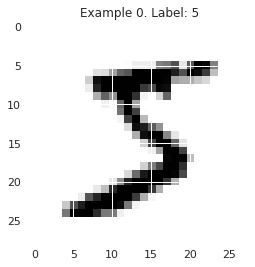

In [9]:
display_image(0)

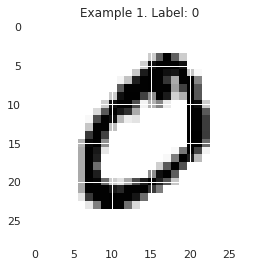

In [10]:
display_image(1)

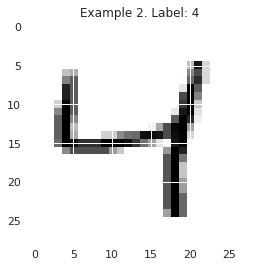

In [11]:
display_image(2)

#### Plot training data

In [12]:
train_labels_count = np.unique(train['labels'], return_counts=True)
dataframe_train_labels = pd.DataFrame({'Label':train_labels_count[0], 'Count':train_labels_count[1]})
dataframe_train_labels

,Label,Count
0,0,5923
1,1,6742
2,2,5958
3,3,6131
4,4,5842
5,5,5421
6,6,5918
7,7,6265
8,8,5851
9,9,5949


### Split training data into training and validation

In [0]:
validation = {}
train['features'], validation['features'], train['labels'], validation['labels'] = train_test_split(train['features'], train['labels'], test_size=0.2, random_state=0)

In [14]:
print('# of training images:', train['features'].shape[0])
print('# of validation images:', validation['features'].shape[0])

# of training images: 48000
# of validation images: 12000


## 2. Prepare our input features

The LeNet architecture accepts a 32x32 pixel images as input, mnist data is 28x28 pixels. We simply pad the images with zeros to overcome that.

In [15]:
# Pad images with 0s
train['features']      = np.pad(train['features'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
validation['features'] = np.pad(validation['features'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
test['features']       = np.pad(test['features'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
    
print("Updated Image Shape: {}".format(train['features'][0].shape))

Updated Image Shape: (32, 32, 1)


## 3. LeNet-5 implmentation

![lenet.png](https://raw.githubusercontent.com/MostafaGazar/mobile-ml/master/files/lenet.png)
>>> LeNet-5 Architecture. Credit: [LeCun et al., 1998](http://yann.lecun.com/exdb/publis/psgz/lecun-98.ps.gz)



**The following part is heavily inspired by** https://github.com/udacity/CarND-LeNet-Lab/blob/master/LeNet-Lab-Solution.ipynb

#### Input
    32x32x1 pixels image

#### Architecture
* **Convolutional #1** outputs 28x28x6
    * **Activation** any activation function, we will `relu`

* **Pooling #1** The output shape should be 14x14x6.

* **Convolutional #2** outputs 10x10x16.
    * **Activation** any activation function, we will `relu`

* **Pooling #2** outputs 5x5x16.
    * **Flatten** Flatten the output shape of the final pooling layer

* **Fully Connected #1** outputs 120
    * **Activation** any activation function, we will `relu`

* **Fully Connected #2** outputs 84
    * **Activation** any activation function, we will `relu`

* **Fully Connected (Logits) #3** outpute 10


In [16]:
model = keras.Sequential()

model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,1)))
model.add(layers.AveragePooling2D())

model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(layers.AveragePooling2D())

model.add(layers.Flatten())

model.add(layers.Dense(units=120, activation='relu'))

model.add(layers.Dense(units=84, activation='relu'))

model.add(layers.Dense(units=10, activation = 'softmax'))

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 6)         60        
_________________________________________________________________
average_pooling2d_1 (Average (None, 15, 15, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 16)        880       
_________________________________________________________________
average_pooling2d_2 (Average (None, 6, 6, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               69240     
_________________________________________________________________
dense_2 (Dense)              (None, 84)               

In [18]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [0]:
EPOCHS = 10
BATCH_SIZE = 128

In [0]:
X_train, y_train = train['features'], to_categorical(train['labels'])
X_validation, y_validation = validation['features'], to_categorical(validation['labels'])

train_generator = ImageDataGenerator().flow(X_train, y_train, batch_size=BATCH_SIZE)
validation_generator = ImageDataGenerator().flow(X_validation, y_validation, batch_size=BATCH_SIZE)

In [21]:
print('# of training images:', train['features'].shape[0])
print('# of validation images:', validation['features'].shape[0])

steps_per_epoch = X_train.shape[0]//BATCH_SIZE
validation_steps = X_validation.shape[0]//BATCH_SIZE

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_generator, validation_steps=validation_steps, 
                    shuffle=True, callbacks=[tensorboard])

# of training images: 48000
# of validation images: 12000
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where










Epoch 1/10
375/375 [==============================] - 8s 20ms/step - loss: 0.9212 - acc: 0.8848 - val_loss: 0.0946 - val_acc: 0.9693

Epoch 2/10
375/375 [==============================] - 4s 12ms/step - loss: 0.0740 - acc: 0.9766 - val_loss: 0.0641 - val_acc: 0.9810
Epoch 3/10
375/375 [==============================] - 4s 11ms/step - loss: 0.0464 - acc: 0.9853 - val_loss: 0.0523 - val_acc: 0.9836
Epoch 4/10
375/375 [==============================] - 4s 11ms/step - loss: 0.0361 - acc: 0.9881 - val_loss: 0.0541 - val_acc: 0.9841
Epoch 5/10
375/375 [==============================] - 4s 12ms/step - loss: 0.0287 - acc: 0.9909 - val_loss: 0.0551 - val_acc: 0.9837
Epoch 6/10
375/375 [==============================] - 4s 12ms/step - loss: 0.0242 - acc: 0.9919 - val_loss: 0.0537 - val_acc: 0.9846
Epoch 7/10
375/375 [===================

In [22]:
score = model.evaluate(test['features'], to_categorical(test['labels']))
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 1s 74us/step
Test loss: 0.05078238661806877
Test accuracy: 0.9866


In [23]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

LOG_DIR = 'logs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

get_ipython().system_raw('./ngrok http 6006 &')

--2019-10-30 19:58:01--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.7.140.64, 52.71.139.107, 34.202.125.55, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.7.140.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  14.4MB/s    in 0.9s    

2019-10-30 19:58:02 (14.4 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [24]:
ngrok_url = !curl -s http://localhost:4040/api/tunnels | python -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"
        
ngrok_url = ngrok_url[0].replace("'", '')
print(ngrok_url)

https://0177fa8c.ngrok.io


In [0]:
from IPython.display import IFrame

IFrame(ngrok_url, width=700, height=900)